In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")
# hi_maps= np.load("/home/urwa/MASS_Thesis/HI/hi_corr_maps.npy")
noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")
ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")

# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
# noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

fgds=(ff+sync)/2e8
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
*_,noise_binned= bin_spectra(cl_noise, 10)
*_, fgds_binned= bin_spectra(cl_fgds, 10)
total=hi_maps + noise_maps[:54] +fgds
cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
*_, chat_binned= bin_spectra(cl_hat, 10)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [6]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

In [7]:
bins=7

In [8]:
def build_trapezoidal_basis(freqs, bin, top_width=0.5):
    """
    Create trapezoidal basis functions (___/----\___) on frequency grid.
    
    Parameters:
    - freqs: 1D array of frequency bin centers (nf,)
    - n_bins: number of trapezoidal functions (i.e., nq)
    - top_width: fraction of bin width used for the flat top (0 < top_width < 1)

    Returns:
    - phi: shape (n_bins, nf), the basis matrix
    """
    nf = len(freqs)
    vmin, vmax = freqs[0], freqs[-1]
    bin_edges = np.linspace(vmin, vmax, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    flat_top = top_width * bin_width
    slope_width = (1 - top_width) * bin_width / 2  #slope= 1/slope_width

    phi = np.zeros((bin, nf))

    for i in range(bin):
        # Define edges of the trapezoid
        left = bin_edges[i] - slope_width
        start_flat = bin_edges[i]
        end_flat = bin_edges[i + 1]
        right = bin_edges[i + 1] + slope_width

        for j, v in enumerate(freqs):
            if left <= v < start_flat:
                phi[i, j] = (v - left) / slope_width
            elif start_flat <= v <= end_flat:
                phi[i, j] = 1.0
            elif end_flat < v <= right:
                phi[i, j] = (right - v) / slope_width
            else:
                phi[i, j] = 0.0

    return phi


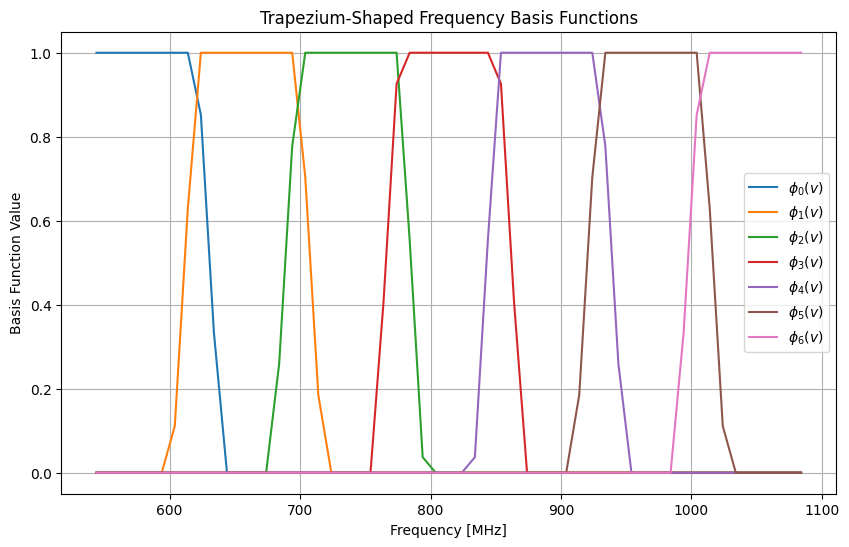

In [9]:
import matplotlib.pyplot as plt
phi= build_trapezoidal_basis(freqs, bins)
# Plot each basis function (each row of phi)
plt.figure(figsize=(10, 6))
for i in range(phi.shape[0]):
    plt.plot(freqs, phi[i], label=f"$\phi_{{{i}}}(v)$")

plt.xlabel("Frequency [MHz]")
plt.ylabel("Basis Function Value")
plt.title("Trapezium-Shaped Frequency Basis Functions")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
from itertools import product
from numpy.linalg import lstsq

P, Q = 5,bins-1  #degree
v0=freqs[23]
n=0.5

# Step 1: Extract diagonal
nell, nf, _ = hi_d.shape
C_diag = np.array([np.diag(hi_d[i]) for i in range(nell)])  # shape (nell, nf)

# Step 2: Log coordinates
log_l = np.log10(leff)  # shape (nell,)
log_v = np.log10(freqs[:-1])  # shape (nf,)
scaling = (freqs[:-1] / v0)**(-n)  # shape (nf,)

# Step 3: Build hat-shaped basis
phi = build_trapezoidal_basis(freqs[:-1], bins)  # shape (nq, nf)
# Unnormalized Psi: each row is φ_q(v) * scaling
Psi_unnorm = phi * scaling[None, :]  # shape (nq, nf)

# Normalize across q (rows) for each v (column)
Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)
print(Psi.shape)# shape (nq, nf)
# Psi = phi * scaling[None, :]              # shape (nq, nf)

# Step 4: Build coeff matrix
basis_terms = list(product(range(P + 1), range(Q + 1))) # all (p, q) pairs (0,0), (0,1), ..., (P,Q)
n_terms = len(basis_terms) # total number of basis functions (P + 1) * (Q + 1)

X = np.zeros((nell * nf, n_terms))# rows = data points, cols = basis terms
y = C_diag.reshape(-1) #flatten target values to shape (nell * nf,)
print(y.shape)
print(len(leff)*nf)

for i, (p, q) in enumerate(basis_terms):
    # Outer product: (nell,) x (nf,) → shape (nell, nf)
    X[:, i] = np.outer(log_l**p, Psi[q]).reshape(-1)

# Step 5: Solve least mean squares
a_vec, residuals, rank, s = lstsq(X, y, rcond=None)
a_matrix = a_vec.reshape((P + 1, Q + 1))  # shape (P+1, Q+1)
print(a_matrix.shape)
print(a_vec.shape)

# # Step 6: Reconstruct the fitted diagonal
# C_fit_diag = np.zeros((nell, nf))
# for p in range(P + 1):
#     for q in range(Q + 1):
#         C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

# # Step 7: Expand to full (nell, nf, nf) with diagonal only
# C_fit = np.zeros((nell, nf, nf))
# for i in range(nell):
#     np.fill_diagonal(C_fit[i], C_fit_diag[i])


(7, 54)
(4104,)
4104
(6, 7)
(42,)


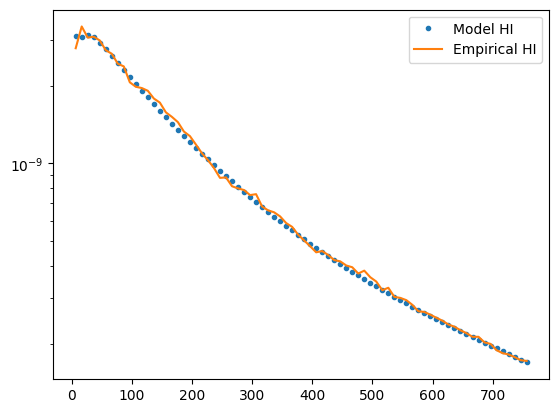

In [126]:
def model_cov_and_grad(a_k, logl, trapezoid, poly):
    """
    Build full (diagonal-only) HI model covariance and its gradient.

    Parameters
    ----------
    a_vec : ndarray, shape ((P+1)*(Q+1),)
        Flattened coefficient vector.
    logl : ndarray, shape (nell,)
        Log10 of multipole values.
    Psi : ndarray, shape (Q+1, nf)
        Frequency basis functions.
    P : int
        Maximum power of log(l).

    Returns
    -------
    R_HI : ndarray, shape (nell, nf, nf)
        Full modeled HI covariance (diagonal-only).
    dR_HI_da : ndarray, shape (nell, nf, nf, (P+1)*(Q+1))
        Gradient of R_HI with respect to a_vec.
    """
    nell = len(leff)
    Q1, nf = trapezoid.shape  # Q+1 frequency bins
    R_HI_diag = np.zeros((nell, nf))
    dR_diag_da = np.zeros((nell, nf, (poly+1)*(Q1)))

    a_matrix = a_k.reshape((poly+1, Q1))

    for p in range(poly+1):
        logl_p = logl**p  # (nell,)
        for q in range(Q1):
            term = np.outer(logl_p, trapezoid[q])  # shape (nell, nf)
            R_HI_diag += a_matrix[p, q] * term
            dR_diag_da[:, :, p * Q1 + q] = term

    # Expand to full (nell, nf, nf) diagonal matrices
    R_HI = np.zeros((nell, nf, nf))
    dR_HI_da = np.zeros((nell, nf, nf, (poly+1)*(Q1)))
    for i in range(nell):
        # np.fill_diagonal(R_HI[i], R_HI_diag[i])
        R_HI[i,:,:] = np.diag(R_HI_diag[i])
        for j in range((poly+1)*(Q1)):
            # np.fill_diagonal(dR_HI_da[i, :, :, j], dR_diag_da[i, :, j])
            dR_HI_da[i, :, :, j] = np.diag(dR_diag_da[i, :, j])
    
    return R_HI, dR_HI_da

mod, grad = model_cov_and_grad(a_vec, log_l, Psi, P)
plt.plot(leff, mod[:, 34, 34], '.', label='Model HI')
plt.plot(leff, hi_d[:, 34, 34], label='Empirical HI')
plt.yscale('log')
plt.legend()

In [127]:
def smica_cost(a_k, logl, trapezoid, R_data, R_fg, R_noise,poly):
    B, nf = R_data.shape[0], R_data.shape[1]
    Qu = trapezoid.shape[0]
    n_coeffs = (poly + 1) * Qu
    phi = 0.0
    
    

    for b in range(B):  # loop over ell bins
        logl_b = logl[b]         # scalar
        R_fg_b = R_fg[b]         # (nf, nf)
        R_noise_b = R_noise[b]   # (nf, nf)
        R_data_b = R_data[b]     # (nf, nf)

        C_HI_diag_b,_= model_cov_and_grad(a_k, logl_b, trapezoid, poly)
        # print(C_HI_diag_b.shape)
        

        # R_HI_b = np.diag(C_HI_diag_b)
        R_model_b = C_HI_diag_b[b] + R_fg_b + R_noise_b # (nf, nf)
        R_model_inv_b = np.linalg.inv(R_model_b)   # (nf, nf)

        # Compute cost terms
        logdet_term = np.linalg.slogdet(R_data_b @ R_model_inv_b)[1]
        # print(logdet_term.shape)
        tr_term = np.trace(R_data_b @ R_model_inv_b)
        # print(tr_term.shape)
        phi +=  (tr_term - logdet_term - nf) #n_b[b] * ((2*leff[b]+1)*10)*
    return phi

smica_cost(a_vec, log_l, Psi,chat_binned, fgds_binned, noise_binned, P)

np.float64(60.50911048896056)

In [128]:
def jacobian(a_k, logl, trapezoid, R_data, R_fg, R_noise,poly):
    B, nf = R_data.shape[0], R_data.shape[1]
    Qu = trapezoid.shape[0]
    n_coeffs = (poly + 1) * Qu
    
    R_HI_b, dR_HI_da = model_cov_and_grad(a_k, logl, trapezoid, poly)
    # print(R_HI_b.shape)
    # print(dR_HI_da.shape)
    grad = np.zeros(n_coeffs)
    for b in range(B):
        logl_b = logl[b]         # scalar
        R_fg_b = R_fg[b]         # (nf, nf)
        R_noise_b = R_noise[b]   # (nf, nf)
        R_data_b = R_data[b]     # (nf, nf)

        # R_HI_b = np.diag(C_HI_diag_b)
        R_model_b = R_HI_b[b] + R_fg_b + R_noise_b # (nf, nf)
        R_model_inv_b = np.linalg.inv(R_model_b)   # (nf, nf)
        
        # Compute gradient w.r.t. each coefficient
        for p in range(poly + 1):
            for q in range(Qu):
                idx = q * (poly + 1) + p
                dR = dR_HI_da[b, :, :, idx] # derivative of R_HI w.r.t a_pq #nfxnf
                # print(dR.shape)
                Delta= R_model_inv_b - R_model_inv_b @ R_data_b @ R_model_inv_b
                # dphi = - R_model_inv_b @ dR @ R_model_inv_b @ R_data_b + R_model_inv_b @ dR
                dphi=Delta @ dR
                # print(dphi.shape)
                grad[idx] += np.trace(dphi) # n_b[b] *((2*leff[b]+1)*10)*
    
    return grad
jacobian(a_vec, log_l, Psi, chat_binned, fgds_binned, noise_binned, P)

array([-2.05884600e+09, -1.98073454e+10, -2.08601258e+09, -5.49706802e+08,
        1.05338404e+09,  1.11645603e+09,  2.04070852e+09, -6.54645709e+09,
       -5.65290312e+10, -6.32099742e+09, -1.16122270e+09,  3.47892918e+09,
        4.37744369e+09,  6.24799718e+09, -2.04794741e+10, -1.61945052e+11,
       -1.89553168e+10, -2.50839617e+09,  1.10951280e+10,  1.56003791e+10,
        1.89792251e+10, -6.34084180e+10, -4.64985812e+11, -5.65989164e+10,
       -5.26805346e+09,  3.47677580e+10,  5.29728671e+10,  5.74963120e+10,
       -1.94847199e+11, -1.33712962e+12, -1.68602430e+11, -1.02264304e+10,
        1.07743215e+11,  1.74480726e+11,  1.73861103e+11, -5.95152026e+11,
       -3.84938551e+12, -5.01417193e+11, -1.65474182e+10,  3.31170143e+11,
        5.62505691e+11,  5.24749145e+11])

In [102]:
from scipy.optimize import approx_fprime
f = lambda x: smica_cost(x, log_l, Psi, chat_binned, fgds_binned, noise_binned,P)

approx_grad = approx_fprime(a_vec, f, epsilon=1e-6) #finite differences
print(approx_grad)

[3.37929071e+09 4.07166186e+09 4.34862882e+09 4.86309164e+09
 4.93988638e+09 5.38756731e+09 5.06977118e+09 4.04119816e+09
 4.85982280e+09 5.08010592e+09 5.66045797e+09 5.67297258e+09
 6.18463188e+09 5.73687478e+09 4.70617674e+09 5.65467493e+09
 5.81320865e+09 6.45992849e+09 6.40683111e+09 6.98395553e+09
 6.40432101e+09 5.37266659e+09 6.45284527e+09 6.54707669e+09
 7.26037997e+09 7.14104274e+09 7.78433097e+09 7.07192107e+09
 6.03995152e+09 7.25270215e+09 7.28132691e+09 8.06131138e+09
 7.87542494e+09 8.58521029e+09 7.73959390e+09 6.70769578e+09
 8.05345934e+09 8.01578614e+09 8.86249614e+09 8.60989707e+09
 9.38634424e+09 8.40730422e+09]


In [129]:
import autograd.numpy as np
from autograd import grad
auto_grad=grad(smica_cost)

answer=auto_grad(a_vec, log_l, Psi, chat_binned, fgds_binned, noise_binned,P)

print(answer)
print(answer.shape)

ValueError: setting an array element with a sequence.

In [115]:
res = optimize.minimize(
    fun=smica_cost,
    x0=a_vec,
    args=(log_l, Psi, chat_binned, fgds_binned, noise_binned, P),
    method='trust-constr',
    # constraints=constraint,
    jac=jacobian,
    options={'disp': True, 'maxiter':3000, 'gtol':1e-3, 'xtol':1e-5,'barrier_tol': 1e-6, 'verbose': 2} #
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +6.0509e+01 | 1.00e+00 | 3.85e+12 | 0.00e+00 |
|   2   |   2   |   1   | +6.0509e+01 | 5.00e-01 | 3.85e+12 | 0.00e+00 |
|   3   |   3   |   2   | +6.0509e+01 | 2.50e-01 | 3.85e+12 | 0.00e+00 |
|   4   |   4   |   3   | +6.0509e+01 | 1.25e-01 | 3.85e+12 | 0.00e+00 |
|   5   |   5   |   4   | +6.0509e+01 | 6.25e-02 | 3.85e+12 | 0.00e+00 |
|   6   |   6   |   5   | +6.0509e+01 | 3.12e-02 | 3.85e+12 | 0.00e+00 |
|   7   |   7   |   6   | +6.0509e+01 | 1.56e-02 | 3.85e+12 | 0.00e+00 |
|   8   |   8   |   7   | +6.0509e+01 | 7.81e-03 | 3.85e+12 | 0.00e+00 |
|   9   |   9   |   8   | +6.0509e+01 | 3.91e-03 | 3.85e+12 | 0.00e+00 |
|  10   |  10   |   9   | +6.0509e+01 | 1.95e-03 | 3.85e+12 | 0.00e+00 |
|  11   |  11   |  10   | +6.0509e+01 | 9.77e-04 | 3.85e+12 | 0.00e+00 |
|  12   |  12   |  11   | +6.0509e+01 | 4.88e-04 | 

(42,)
(6, 7)
(76, 54, 54)


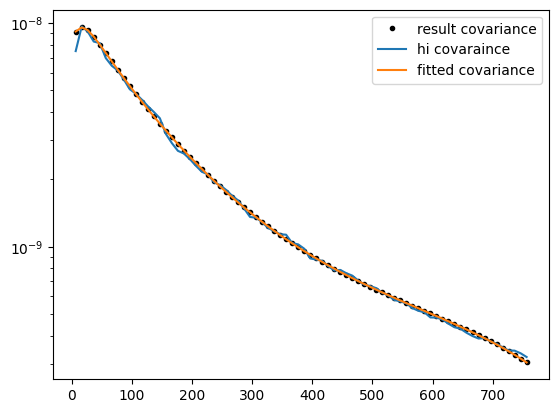

In [112]:
result=res.x
print(result.shape)
a_res = result.reshape((P + 1, bins ))  # shape (P+1, Q+1)
print(a_res.shape)


C_result_diag=np.zeros((nell, nf))

for p in range(P + 1):
    for q in range(Q + 1):
        C_result_diag +=a_res[p, q] * np.outer(log_l**p, Psi[q])

C_result = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_result[i], C_result_diag[i])

print(C_result.shape)
f=19
plt.plot(leff,C_result[:,f,f],'k.', label="result covariance")
# plt.plot(leff,chat_binned[:,f,f], label="empirical covariance")
# plt.plot(leff,C_model[:,f,f], label="model covaraince")
plt.plot(leff, hi_d[:,f,f], label="hi covaraince")
plt.plot(leff,mod[:,f,f], label="fitted covariance")
# plt.plot(leff,noise_binned[:,f,f], label="noise covariance")
# plt.plot(leff, fgds_binned[:,f,f], label="synch+ff cl")
plt.yscale('log')
plt.legend()

In [51]:
def is_psd(func, tol=0):
    eigenvalues = np.linalg.eigvalsh(func)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(C_result))

Is model PSD? True


In [73]:
def fisher_information(a_k, logl, trapezoid, R_fg, R_noise, n_b, poly):
    """
    Compute Fisher Information Matrix for SMICA model.
    
    Parameters:
        a_vec: (n_coeffs,) flattened polynomial coefficients
        logl: (B,) log10(ell_bin_centers)
        Psi: (Q, nf) frequency basis functions
        R_fg: (B, nf, nf)
        R_noise: (B, nf, nf)
        n_b: (B,) number of modes per bin
        P: polynomial degree
    
    Returns:
        FIM: (n_coeffs, n_coeffs) Fisher Information Matrix
    """
    B, nfreqs = R_fg.shape[0], R_fg.shape[1]
    Qu = trapezoid.shape[0]
    n_coeffs = (poly + 1) * Qu

    # Build model + gradient of HI covariances
    R_hi, grad_R_hi = model_cov_and_grad(a_k, logl, trapezoid, poly)  # Shapes: (B, nf, nf), (B, n_coeffs, nf, nf)
    R_Y = R_hi + R_fg + R_noise  # (B, nf, nf)
    # print(R_Y.shape, grad_R_hi.shape)

    FIM = np.zeros((n_coeffs, n_coeffs))

    for b in range(B):
        inv_R = np.linalg.inv(R_Y[b])  # (nf, nf)
        for m in range(n_coeffs):
            dRm = grad_R_hi[b, :, :,m]  # (nf, nf)
            for n in range(m, n_coeffs):
                dRn = grad_R_hi[b,:,:, n]  # (nf, nf)

                # Compute trace term: Tr( R⁻¹ dR_m R⁻¹ dR_n )
                term = inv_R @ dRm @ inv_R @ dRn
                trace_val = np.trace(term)
                FIM[m, n] += 0.5 *  trace_val #n_b[b] *

    # Symmetrize the matrix
    FIM = FIM + FIM.T - np.diag(np.diag(FIM))
    return FIM
F=fisher_information(a_res, log_l, Psi, fgds_binned, noise_binned, ((2*leff+1)*10), P)
inv_fish= np.linalg.inv(F)

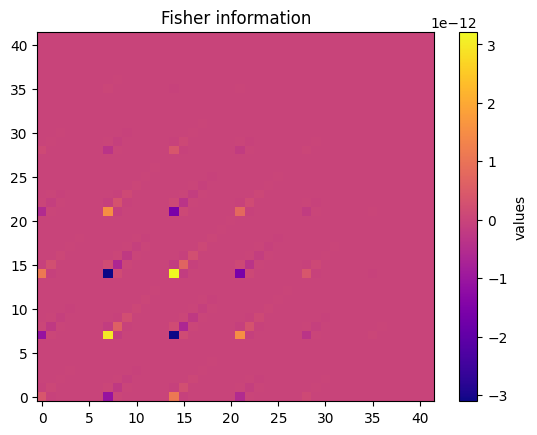

In [79]:
plt.imshow(inv_fish, origin='lower', cmap='plasma', aspect='auto', vmin=np.min(inv_fish), vmax=np.max(inv_fish)) #,, vmin=0, vmax=8.5e-8 vmin=0, vmax=1.5e-9
plt.colorbar(label='values')
plt.title(f"Fisher information")
plt.show()

In [75]:
inv_fish

array([[ 3.99865784e-13, -1.92532463e-14,  5.96191009e-16, ...,
         1.09889545e-18,  9.95925612e-19,  1.32427096e-18],
       [-1.92534587e-14,  7.77983422e-14, -5.23675423e-15, ...,
         1.63049922e-18,  1.76117711e-19,  1.49305340e-19],
       [ 5.96211929e-16, -5.23678911e-15,  2.65601984e-14, ...,
        -4.74821733e-18,  6.46635720e-19,  7.89579117e-20],
       ...,
       [ 1.09886085e-18,  1.63051417e-18, -4.74821255e-18, ...,
         6.09247883e-18, -4.83637000e-19,  2.60251041e-20],
       [ 9.95960089e-19,  1.76119745e-19,  6.46635611e-19, ...,
        -4.83639128e-19,  2.86170602e-18, -2.18442461e-19],
       [ 1.32425080e-18,  1.49308524e-19,  7.89589492e-20, ...,
         2.60252783e-20, -2.18442483e-19,  1.12180345e-18]],
      shape=(42, 42))